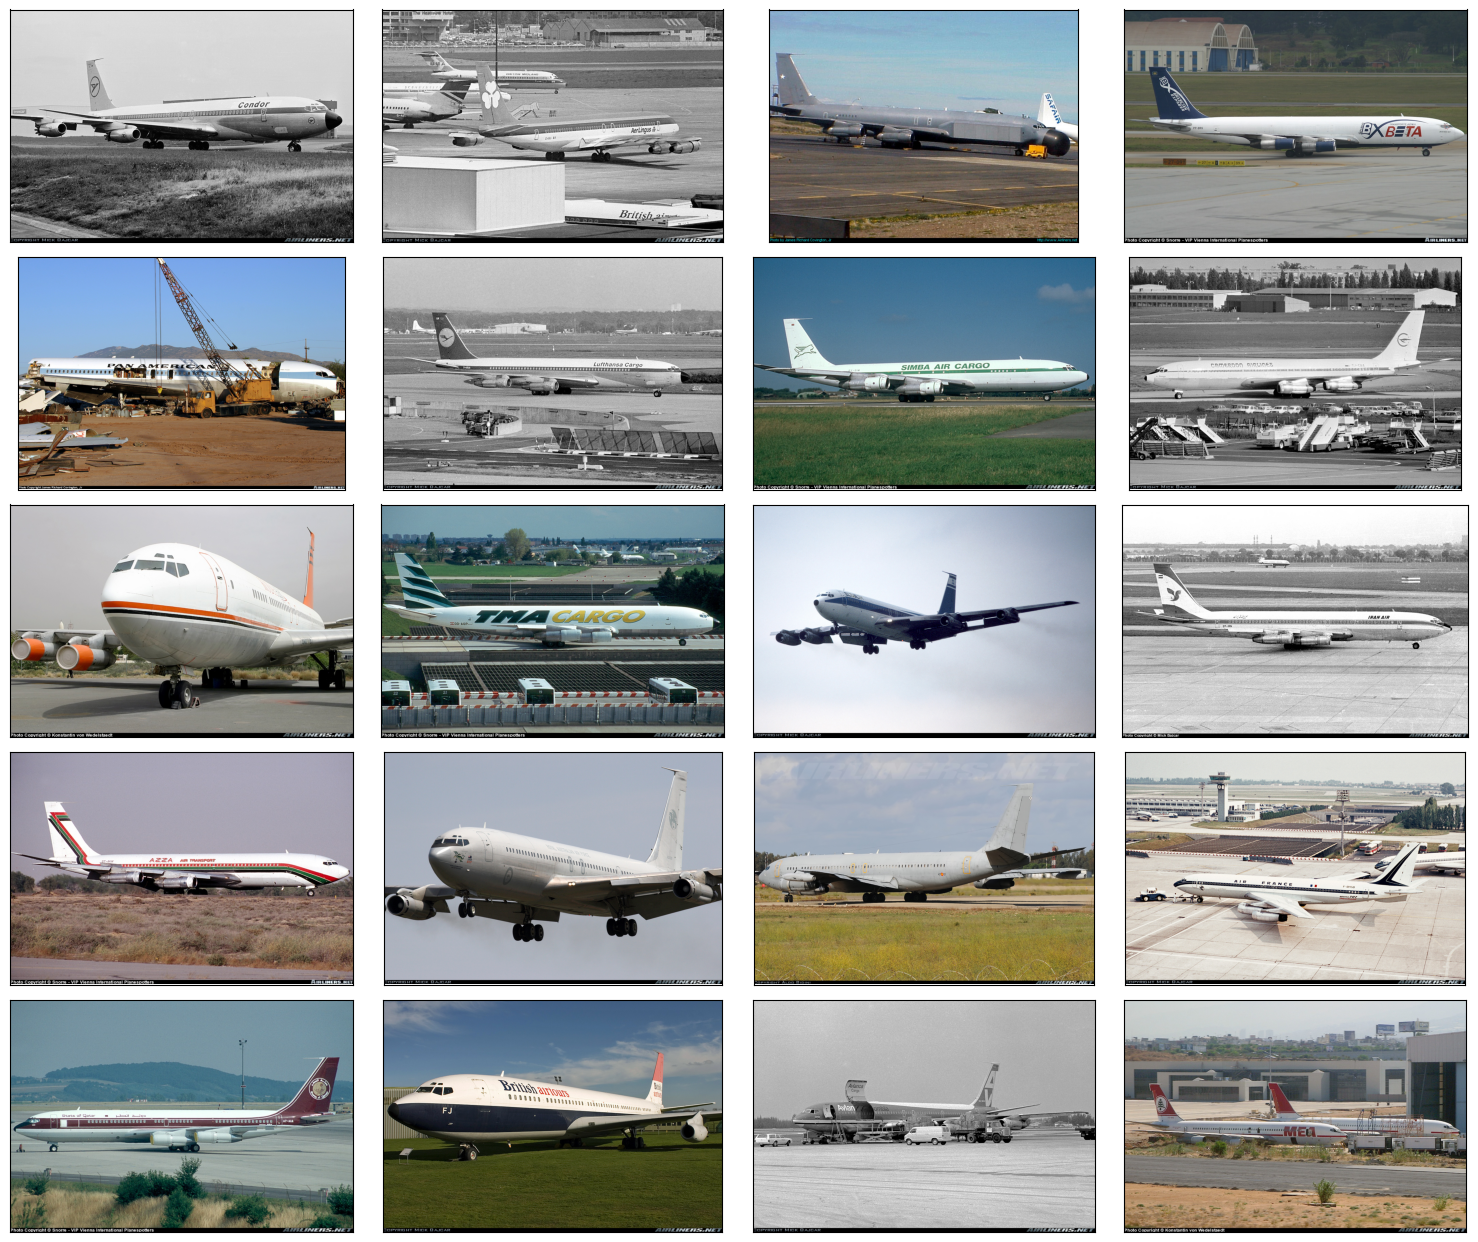

In [7]:
import torch 
import torchvision
import matplotlib.pyplot as plt
import os

def show_images(dataset, num_samples = 20, cols = 4, save_name = None):
    plt.figure(figsize=(15, 15))
    for i , img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(num_samples // cols + 1, cols, i + 1)
        plt.imshow(img[0])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    if save_name:
        os.makedirs("images", exist_ok=True)
        path = os.path.join("images", save_name)
        plt.savefig(path)
    plt.show()

data = torchvision.datasets.FGVCAircraft('./data', download=True)
show_images(data, 20, 4, save_name = "aircrafts.png")

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_Size = 128
Batch_size = 128

def load_transformed_dataset():
    data_transform = transforms.Compose([
        transforms.Resize((IMG_Size, IMG_Size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # transforms to between 0 and 1
        transforms.Lambda(lambda x: x * 2 - 1) # transforms to between -1 and 1
    ])
    
    train = torchvision.datasets.FGVCAircraft('./data', split='train', download=True, transform=data_transform)
    
    test = torchvision.datasets.FGVCAircraft('./data', split='test', download=True, transform=data_transform)
    
    return torch.utils.data.ConcatDataset([train, test])
    
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda x: (x + 1) / 2), # 0 to 1
        transforms.Lambda(lambda x: x.permute(1, 2, 0)), # C x H x W to H x W x C
        transforms.Lambda(lambda x: x * 255), # 0 to 255
        transforms.Lambda(lambda x: x.numpy().astype(np.uint8)), # float to uint8
        transforms.ToPILImage()
    ])
    
    # If the image is a batch, take the first image only
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))
    
data = load_transformed_dataset()
data_loader = DataLoader(data, batch_size=Batch_size, shuffle=True)

## Noise Generator and Forward Diffusion Process

In [12]:
import torch.nn.functional as F
import math

def linear_beta_scheduler(timesteps,start = 0.0001, end = 0.02):
    return torch.linspace(start, end, timesteps)

def tanh_beta_scheduler(timesteps, start = 0.0001, end = 0.02):
    return torch.tensor([start + (end - start) * 0.5 * (1 + math.tanh(4 * (t / timesteps - 0.5))) for t in range(timesteps)])

def cosine_beta_scheduler(timesteps, start = 0.0001, end = 0.02):
    return torch.tensor([start + (end - start) * 0.5 * (1 + math.cos(math.pi * t / timesteps)) for t in range(timesteps)])

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def get_alpha_coeffs(betas):
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis = 0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # prepend 1.0 and remove last element
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas)
    return sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance
    
T = 200
betas = linear_beta_scheduler(T)
sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance = get_alpha_coeffs(betas)

def forward_diffusion_sample(x_0, t, device="cpu", sqrt_alphas_cumprod=sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod):
    noise = torch.randn_like(x_0).to(device)
    mean_coeff = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape).to(device)
    var_coeff = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape).to(device)
    mean = mean_coeff * x_0.to(device)
    var = var_coeff * noise
    return mean + var, noise

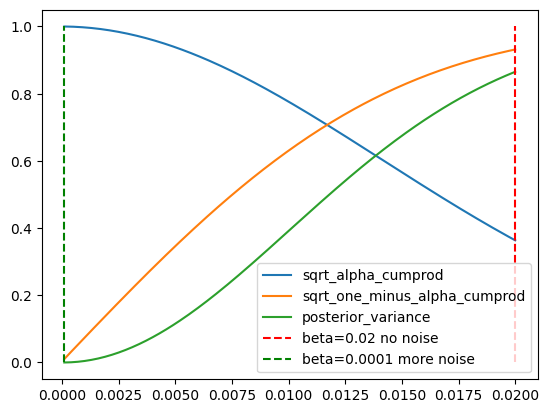

In [13]:
plt.plot(betas, sqrt_alphas_cumprod, label="sqrt_alpha_cumprod")
plt.plot(betas, sqrt_one_minus_alphas_cumprod, label="sqrt_one_minus_alpha_cumprod")
plt.plot(betas, posterior_variance, label="posterior_variance")
plt.vlines(0.02, 0, 1, linestyles='dashed', colors='r', label="beta=0.02 no noise")
plt.vlines(0.0001, 0, 1, linestyles='dashed', colors='g', label="beta=0.0001 more noise")
plt.legend()
plt.show()

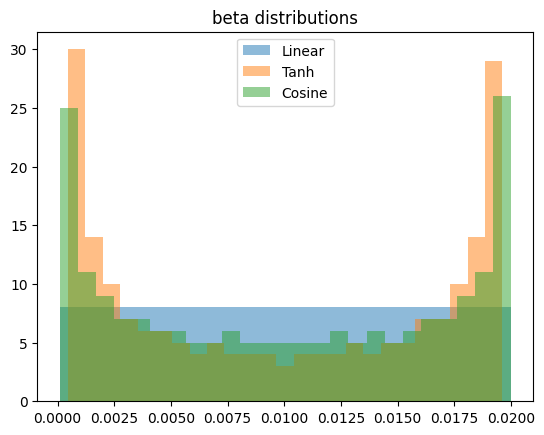

In [14]:
betas_1 = linear_beta_scheduler(T)
betas_2 = tanh_beta_scheduler(T)
betas_3 = cosine_beta_scheduler(T)

plt.hist(betas_1, label="Linear", bins=25, alpha=0.5)
plt.hist(betas_2, label="Tanh", bins=25, alpha=0.5)
plt.hist(betas_3, label="Cosine", bins=25, alpha=0.5)
plt.title("beta distributions")
plt.legend()
plt.show()

In [15]:
def plot_noise_addition(betas, title):
    image = next(iter(data_loader))[0]
    plt.figure(figsize=(20, 5))
    plt.axis = 'off'
    num_images = 10
    stepsize = int(T/num_images)

    sqrt_alphas_cumprod_1, sqrt_one_minus_alphas_cumprod_1, _, _ = get_alpha_coeffs(betas)
    image_ = image
    for idx in range(0, T, stepsize):
        t = torch.Tensor([idx]).type(torch.int64)
        plt.subplot(1, num_images, idx // stepsize + 1)
        image_, noise = forward_diffusion_sample(image_, t, sqrt_alphas_cumprod=sqrt_alphas_cumprod_1, sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod_1)
        show_tensor_image(image_)
    plt.tight_layout()
    plt.title("_".join(title.split(" ")))
    plt.savefig("images/{}.png".format(title))
    plt.show()

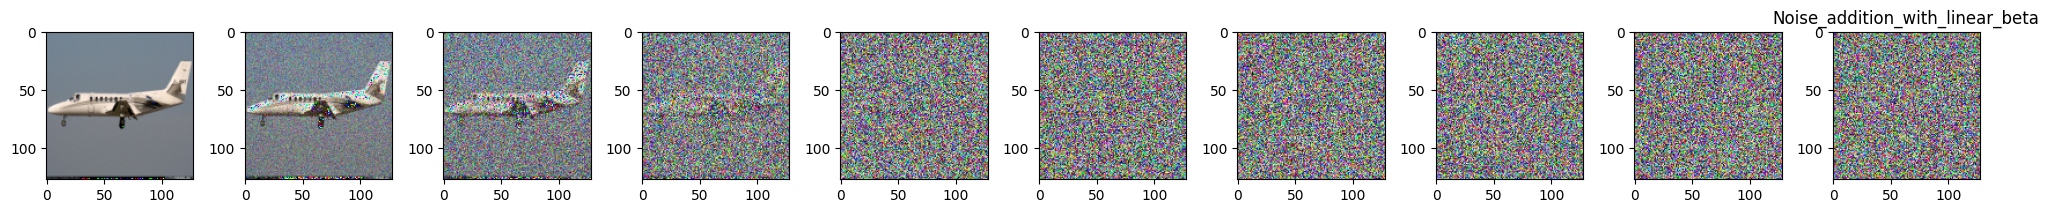

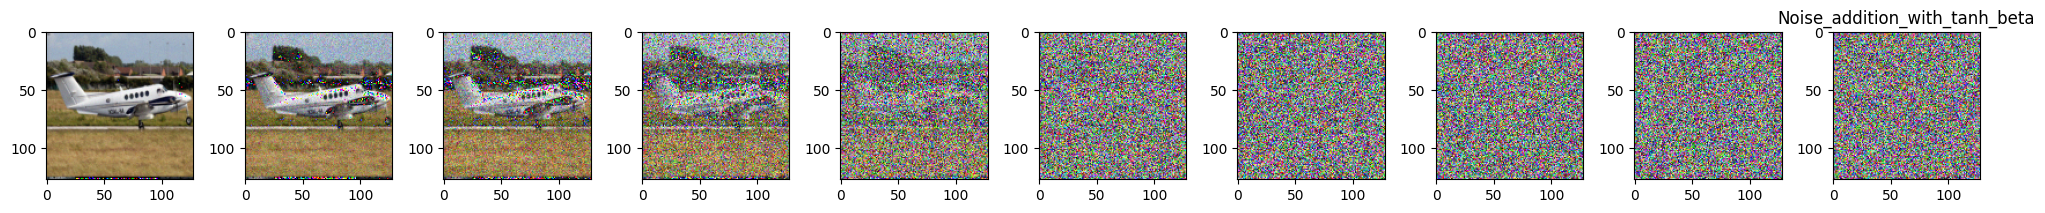

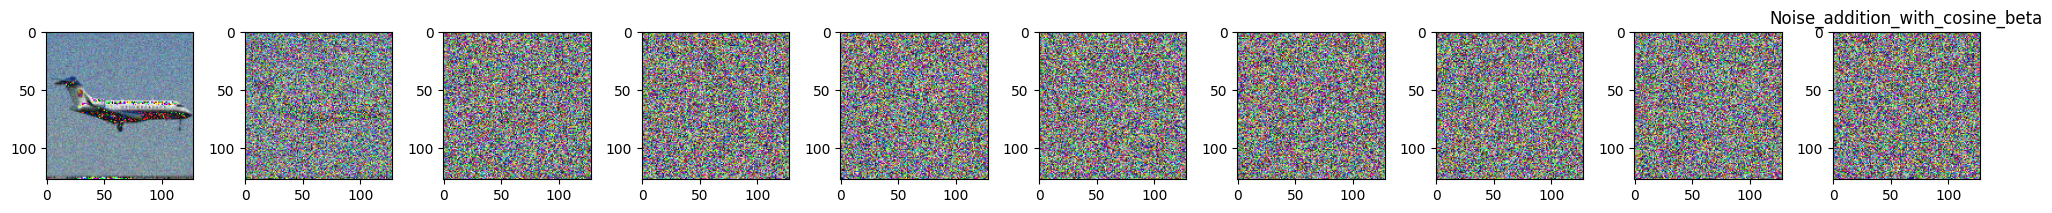

In [16]:
plot_noise_addition(betas_1, "Noise addition with linear beta")
plot_noise_addition(betas_2, "Noise addition with tanh beta")
plot_noise_addition(betas_3, "Noise addition with cosine beta")

In [17]:
final_beta = tanh_beta_scheduler(T)
sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, _, _ = get_alpha_coeffs(final_beta)

tensor([ 24, 197, 180, 112, 187,  90,  30, 126,  71,  19])


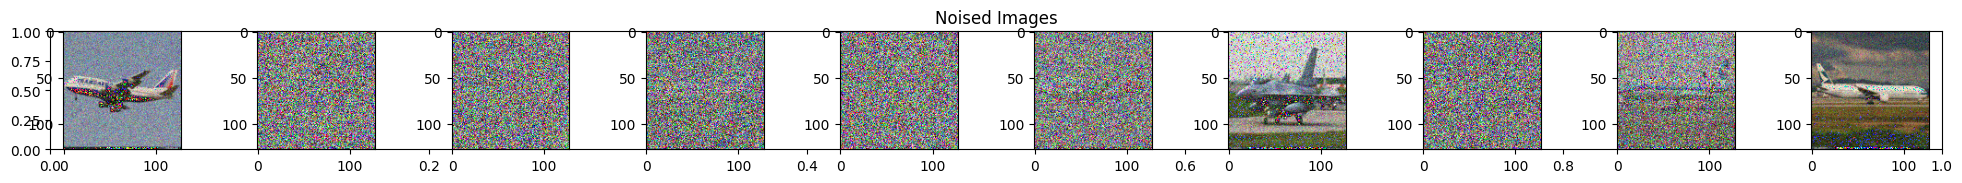

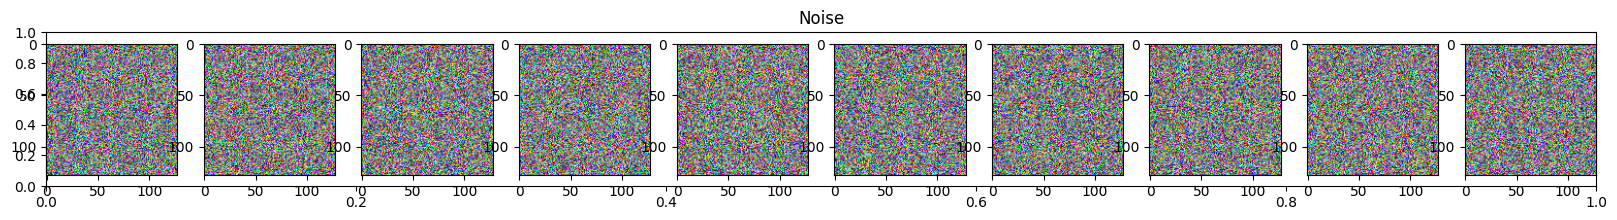

In [18]:
t = torch.randint(0, T, (Batch_size,))
noised_batch, noise = forward_diffusion_sample(next(iter(data_loader))[0], t)
print(t[:10])
plt.figure(figsize=(20, 2))
plt.axis = 'off'
plt.title('Noised Images')
for i in range(10):
    plt.subplot(1, 10, i + 1)
    show_tensor_image(noised_batch[i])
plt.tight_layout()
plt.savefig("images/noised_images.png")
plt.show()
    
plt.figure(figsize=(20, 2))
plt.axis = 'off'
plt.title('Noise')
for i in range(10):
    plt.subplot(1, 10, i + 1)
    show_tensor_image(noise[i])

## Model for diffusion process

In [33]:
import torch.nn as nn
import math

def init_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, up = False, name = None):
        super(Block, self).__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        if up:
            self.conv1 = nn.Conv2d(2*in_channels, out_channels, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, kernel_size = 4, stride = 2, padding = 1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(out_channels, out_channels, kernel_size = 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x, t, ):
        h = self.bnorm(self.relu(self.conv1(x)))
        
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        
        h = h + time_emb
        h = self.bnorm(self.relu(self.conv2(h)))
        
        return self.transform(h)
        
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        image_size = 128
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32
        
        self.time_mlp = nn.Sequential(
            SinusoidalPositionalEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], kernel_size=3, padding=1)
        
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels) - 1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)])
        
        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)
        self.apply(init_weights)
    
    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat([x, residual_x], dim=1)
            x = up(x, t)
        return self.output(x)

model = UNet()
model.to('cpu')
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_parameters}")

Number of parameters: 62433123


AttributeError: 'UNet' object has no attribute 'device'

In [28]:
# forward_pass 
with torch.no_grad():
    output = model(noised_batch, t)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss = criterion(output, noise)
    print(loss)

tensor(4.6655)


In [29]:
def PSNR(loss):
    return 10 * torch.log10(4.0 / torch.sqrt(loss))

def ssim(img1, img2, window_size=11, window=None, size_average=True):
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions.")
    
    if window is None:
        window = create_window(window_size, img1.size(1))
    
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=img1.size(1))
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=img2.size(1))
    
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=img1.size(1)) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=img2.size(1)) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=img1.size(1)) - mu1_mu2
    
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean([1, 2, 3])

def create_window(window_size, channel):
    def gaussian(window_size, sigma):
        window_size = torch.tensor(window_size)
        gauss = torch.Tensor([torch.exp(-(x - window_size//2)**2/(2*sigma**2)) for x in range(window_size)])
        return gauss/gauss.sum()

    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

In [32]:
@torch.no_grad()
def backward_diffusion_sample(x_T, t, model, betas=final_beta, sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas=sqrt_recip_alphas, posterior_variance=posterior_variance):
    device = model.device
    x_T = x_T.to(device)
    betas_t = get_index_from_list(betas, t, x_T.shape).to(device)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_T.shape).to(device)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x_T.shape).to(device)
    mean = sqrt_recip_alphas_t * ( x_T - betas_t * model(x_T, t) / sqrt_one_minus_alphas_cumprod_t )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x_T.shape).to(device)
    if t == 0:
        return mean
    else:
        noise = torch.randn_like(x_T).to(device)
        return mean + posterior_variance_t * noise
    
@torch.no_grad()
def sample_plot_image(model, T):
    img = IMG_Size
    img = torch.randn(1, 3, img, img)
    plt.figure(figsize=(15, 15))
    plt.axis = 'off'
    num_images = 10
    stepsize = int(T/num_images)
    
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, dtype=torch.long)
        img = backward_diffusion_sample(img, t, model)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i // stepsize + 1)
            show_tensor_image(img.detach().cpu()[0])
    plt.show()
    
sample_plot_image(model, T)

AttributeError: 'UNet' object has no attribute 'device'

<Figure size 1500x1500 with 0 Axes>

In [25]:
from torch.optim.lr_scheduler import LambdaLR
import math

def exponential_decay_lr_scheduler(optimizer, decay_rate, epoch):
    def lr_lambda(epoch):
        return math.exp(-decay_rate * epoch)
    return LambdaLR(optimizer, lr_lambda)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
decay_rate = 0.1
scheduler = exponential_decay_lr_scheduler(optimizer, decay_rate, epoch=0)
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for step, (images, _ ) in enumerate(data_loader):
        t = torch.randint(0, T, (Batch_size,))
        noisy_images, noise = forward_diffusion_sample(images, t, device, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
        optimizer.zero_grad()
        outputs = model(noisy_images, t)
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 10 == 0:
            scheduler.step()
            print(f"Epoch {epoch+1}/{num_epochs}, Step {step}/{len(data_loader)}, lr: {optimizer.param_groups[0]['lr']}")
            model.eval()
    lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(data_loader)}, LR: {lr}")
    
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        t = torch.randint(0, T, (Batch_size,))
        noisy_images, noise = forward_diffusion_sample(images, t, device, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
        outputs = model(noisy_images, t)
        loss = criterion(outputs, noise)
        psnr = PSNR(loss)
        ssim_val = ssim(outputs, noise)
        print(f"EPOCH {epoch+1}/{num_epochs}, PSNR: {psnr}, SSIM: {ssim_val}")

KeyboardInterrupt: 